# **Text2RelationGraph**

In order to use this notebook without changing paths and other resources, the following file system structures have to be given.

If you are using this notebook from Google Colab, a Google Drive should be mounted first. There all files should be available in the automatically created 'Colab Notebooks' folder. The structure within this folder is the same as on a local device.

On local devices the FewRel- and Future Engineering training and test data have to be located in seperate folders on root level. The following diagram demonstrates the necessary structure:

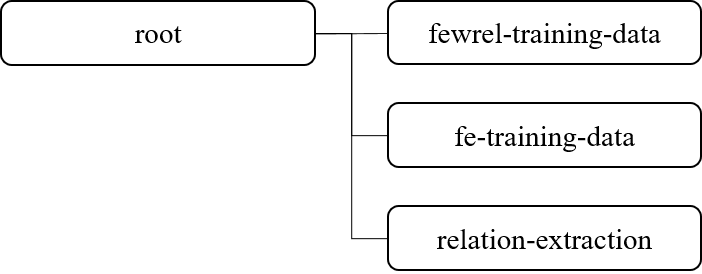


## Imports and environment configuration

In [ ]:
!pip install tagme
!pip install flair
!pip install wptools

!pip install rdflib
!pip install pydotplus
!pip install graphviz

!pip install transformers==3.0.0
!pip install boto3

!pip install lime

!pip install ipython
!pip install ipython-autotime

%load_ext autotime
%tensorflow_version 1.x

In [ ]:
import os
import re
import io
import sys
import time
import json
from pathlib import Path

import tagme
import wptools
from flair.data import Sentence
from flair.models import SequenceTagger
# Set the authorization token for subsequent calls.
tagme.GCUBE_TOKEN = "300c1e74-8bac-4b29-be8f-1e5a75bdcc79-843339462"

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pydotplus
from IPython.display import display, Image
import networkx as nx
from rdflib import Graph, Literal, BNode, RDF, Namespace
from rdflib.tools.rdf2dot import rdf2dot
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph

import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

from itertools import combinations
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report

if 'google.colab' in str(get_ipython()):
  print('Running on Google Colab')
  root = '/content/drive/My Drive/Colab Notebooks/'
else:
  print('Running locally')
  root = Path(os.getcwd()).parent

basepath = os.path.join(root, 'relation-extraction/')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Running on Google Colab
time: 11.2 s


Switch for data usage: If False Future Engineering data will be used, if True FewRel data is used

In [ ]:
use_fewrel_data=False

Building dictionary mapping relation ids to relation names

In [ ]:
if (use_fewrel_data):
    id2rel_dict = dict()
    id2rel_dict['NOTA'] = ['NOTA', 'None of the above']
    id2rel_dict['P105'] = ['taxon rank', 'level in a taxonomic hierarchy']
    id2rel_dict['P135'] = ['movement', 'literary, artistic, scientific or philosophical movement associated with this person or work']
    id2rel_dict['P155'] = ['follows', 'immediately prior item in a series of which the subject is a part']
    id2rel_dict['P31'] = ['instance of', 'that class of which this subject is a particular example and member']
    id2rel_dict['P800'] = ['notable work', 'notable scientific, artistic or literary work, or other work of significance among subject\'s works']
    id2rel_dict['P921'] = ['main subject', 'primary topic of a work']

    rel2id_map = {'P105':0, 'P135':1, 'P155':2, 'P31':3, 'P800':4, 'P921':5, 'NOTA':6}
else:
    id2rel_dict = dict()
    id2rel_dict['NOTA'] = ['NOTA', 'None of the above']
    id2rel_dict['A manufactures product B'] = ['A manufactures B', 'A manufactures B']
    id2rel_dict['A operates B'] = ['A operates B', 'A operates B']
    id2rel_dict['A operates \[something\] in location B'] = ['A operates sth in B', 'A operates sth in B']
    id2rel_dict['A orders B'] = ['A orders B', 'A orders B']
    id2rel_dict['A uses/employs charging technology B'] = ['A uses/employs B', 'A uses/employs B']
    id2rel_dict['A orders something from B'] = ['A orders sth from B', 'A orders sth from B']

    rel2id_map = {'NOTA':0, 'A manufactures product B':1, 'A operates B':2, 'A operates \[something\] in location B':3, 'A orders B':4, 'A uses/employs charging technology B':5, 'A orders something from B':6}

## Entity identifcation and annotation functions

Helper function which converts Wikipedia page titles to Wikidata identifier.




In [ ]:
def get_wikidata_id(entity_name):
    try:
        return wptools.page(entity_name, silent=True).get_query().data['wikibase']
    except:
        return None

Using Flair NLP for identifying and annotating entities within a sentence.

In [ ]:
tagger = SequenceTagger.load('ner')

def get_flair_ents(sentence):
    sent = Sentence(sentence)
    tagger.predict(sent)
    ents = []
    for ent in sent.to_dict(tag_type='ner')['entities']:
        wikidata_id = get_wikidata_id(ent['text'])
        if (wikidata_id is not None):
            ents.append([wikidata_id, ent['start_pos'], ent['end_pos'], 1.0, ent['text']])
    return ents

Using Tagme for identifying and annotating entities within a sentence.

In [ ]:
def get_tagme_ents(sentence, threshold):
    annotated_sent = tagme.annotate(sentence)
    ents = []
    # Keep annotations with a score higher than threshold
    for a in annotated_sent.get_annotations(threshold):
        wikidata_id = get_wikidata_id(a.entity_title)
        if (wikidata_id is not None):
            ents.append([wikidata_id, a.begin, a.end, a.score, a.entity_title])
    return ents  

Wrapper function which lets you decide which framework to use when identifying the entities in a sentence.

In [ ]:
def get_entities_from_sentence(sentence, threshold=0.25, use_tagme=True):
    ents = []
    if (use_tagme):
        for ent in get_tagme_ents(sentence, threshold):
            if (ent[0] not in [item[0] for item in ents]):
                ents.append(ent)
    else:
        for ent in get_flair_ents(sentence):
            if (ent[0] not in [item[0] for item in ents]):
                ents.append(ent)
    return ents

### Evaluation of Tagme and Flair framework

Different sentences are given to the frameworks to be able to compare the found entities and decide which framework to use for inference of new data. Sentences are taken from the Future Engineering Corpus for E-mobility as well as some self defined sentences.

In [ ]:
sentences = []
sentences.append('VAG is also testing the use of Volvo\'s 7900E model on some of their lines in Nuremberg.')
sentences.append('MAN relies on the fully developed lithium-ion (NMC) battery cell technology from the Group’s modular kit.')
sentences.append('National Express has undertaken to stop procuring diesel buses and to convert its bus fleet completely to electric vehicles by 2030.')
sentences.append('The cities of Marseille and Le Havre also have Irizar e-mobility electric vehicles.')
sentences.append('All of them were made by Solaris.')
sentences.append('OCTA operates more than 500 buses in the regular OC Bus system across Orange County.')
sentences.append('In the Netherlands, Keolis relies on electric buses from BYD.')
sentences.append('Just under two weeks ago the Opel subsidiary Vauxhall received a large order for electric vehicles.')
sentences.append('And according to their statements, they are the first company in the country to order ten Tesla Semi.')
sentences.append('For hydrogen projects in France and Denmark, Keolis uses different fuel cell buses from Van Hool.')

for sentence in sentences:
    print('Sentence: %s' % sentence)
    print('Flair ents: %s' % get_flair_ents(sentence))
    print('Tagme ents: %s' % get_tagme_ents(sentence, 0.25))

Sentence: VAG is also testing the use of Volvo's 7900E model on some of their lines in Nuremberg.
Flair ents: [['Q234804', 0, 3, 1.0, 'VAG'], ['Q163810', 31, 36, 1.0, 'Volvo'], ['Q2090', 77, 86, 1.0, 'Nuremberg']]
Tagme ents: [['Q156578', 0, 3, 0.3719039559364319, 'Volkswagen Group'], ['Q163810', 31, 36, 0.40779757499694824, 'Volvo'], ['Q2090', 77, 86, 0.2704906463623047, 'Nuremberg']]
Sentence: MAN relies on the fully developed lithium-ion (NMC) battery cell technology from the Group’s modular kit.
Flair ents: [['Q225298', 0, 3, 1.0, 'MAN'], ['Q395580', 47, 50, 1.0, 'NMC'], ['Q654302', 85, 90, 1.0, 'Group']]
Tagme ents: []
Sentence: National Express has undertaken to stop procuring diesel buses and to convert its bus fleet completely to electric vehicles by 2030.
Flair ents: [['Q60188', 0, 16, 1.0, 'National Express']]
Tagme ents: [['Q6972520', 0, 16, 0.3248792290687561, 'National Express (song)'], ['Q5638', 82, 85, 0.33427536487579346, 'Bus'], ['Q13629441', 106, 123, 0.34948599338531

## Text processing functions

Simple preprocessing of sentences in order to receive better results when inferencing.

In [ ]:
def process_sent(sent):
    if sent not in [" ", "\n", ""]:
        sent = sent.strip("\n")
        sent = re.sub('<[A-Z]+/*>', '', sent) # remove special tokens eg. <FIL/>, <S>
        sent = re.sub(r"[\*\"\n\\…\+\-\/\=\(\)‘•€\[\]\|♫:;—”“~`#]", " ", sent)
        sent = re.sub(' {2,}', ' ', sent) # remove extra spaces > 1
        sent = re.sub("^ +", "", sent) # remove space in front
        sent = re.sub(r"([\.\?,!]){2,}", r"\1", sent) # remove multiple puncs
        sent = re.sub(r" +([\.\?,!])", r"\1", sent) # remove extra spaces in front of punc
        return sent
    return

def process_lines(text):
    text = [process_sent(sent) for sent in text]
    text = " ".join([t for t in text if t is not None])
    text = re.sub(' {2,}', ' ', text) # remove extra spaces > 1
    return text

Helper function for reading input data and splitting up into single sentences.

In [ ]:
def get_sentences_from_text_file(file_path):
    print('Reading input data ...')
    with open(file_path, "r", encoding="utf8") as f:
        text = process_lines(f.readlines())

    print('Splitting text in sentences ...')
    return sent_tokenize(text)

## RDF-Graph Creation and modification functions

Using rdflib for creation of a knowledge graph. Adding one statement for each found relation in a text.

In [ ]:
fraun_rel = Namespace("http://iis.fraunhofer.com/fe/relations#")
wikidata = Namespace("http://www.wikidata.org/entity/")

In [ ]:
def get_rdf_graph_from_inference_results(inference_results, readable_names=False):
    graph = Graph()
    graph.bind("rel", fraun_rel)
    graph.bind("ent", wikidata)

    for ent1, relation, ent2 in inference_results:
        if (relation != 'NOTA'):
            if (readable_names):
                graph.add((wikidata[ent1[2].replace(' ','_').replace('/','_')], fraun_rel[relation.replace(' ','_').replace('/','_')], wikidata[ent2[2].replace(' ','_').replace('/','_')]))
            else:
                graph.add((wikidata[ent1[0]], fraun_rel[relation.replace(' ','_').replace('/','_')], wikidata[ent2[0]]))
    return graph

Helper function for saving the graph to an png file containing its structure.

In [ ]:
def save_rdf_graph_as_png(graph, file_name):
    stream = io.StringIO()
    rdf2dot(graph, stream, opts = {display})
    pydotplus.graph_from_dot_data(stream.getvalue()).write_png(file_name)

Helper function for converting the graph to a networkx graph and saving it to a graphml file.

In [ ]:
def save_rdf_graph_as_graphml(graph, file_name):
    nx_graph = rdflib_to_networkx_multidigraph(graph)
    nx.write_graphml(nx_graph, file_name)

In [ ]:
def save_rdf_graph_as_turtle(graph, file_name):
    graph.serialize(destination=file_name, format='turtle')

## ERNIE Inference

In [ ]:
sys.path.append(os.path.join(basepath, 'ERNIE/code'))

from knowledge_bert.tokenization import BertTokenizer as ERNIEBertTokenizer
from knowledge_bert.modeling import BertForSequenceClassification as ERNIEBertForSequenceClassification

Definition of some parameters which are needed when initializing the inferencer class in order to load a pretrained model and additional resources.

In [ ]:
ernie_num_labels_task = 7
ernie_max_seq_length = 100
ernie_entity2id_file = os.path.join(basepath, 'ERNIE/kg_embed/entity2id.txt')
ernie_entity_vector_file = os.path.join(basepath, "ERNIE/kg_embed/entity2vec.vec")

if (use_fewrel_data):
    # FewRel model
    ernie_model_file = os.path.join(basepath, 'ERNIE/output_fewrel/pytorch_model_7_classes_200_examples.bin')
    ernie_label_map = os.path.join(basepath, 'ERNIE/output_fewrel/label_map_7_classes_200_examples.json')
else:
    # Future Engineering model
    ernie_model_file = os.path.join(basepath, 'ERNIE/output_fe/pytorch_model_fe_large_7_classes.bin')
    ernie_label_map = os.path.join(basepath, 'ERNIE/output_fe/label_map_fe_large_7_classes.json')

The following code defines an inferencer class using ERNIE approach for relation extraction. 

The inferencer class is able to inference a not annotated sentence which the ERNIE model was not trained on as well as any annotated sentence from a dataset. 

The input of the inference method is a sentence and two entities contained in the given sentence with their respective position.

In [ ]:
class ErnieInferencer():
    def __init__(self, model_file, label_map_file, num_labels, max_seq_length, entity2id_file, entity_vector_file, threshold=0.0):
        print('Instantiating ErnieInferencer')
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.max_seq_length = max_seq_length

        print('Loading pretrained tokenizer and model ...')
        model_name = os.path.join(basepath, 'ERNIE/ernie_base')
        self.tokenizer = ERNIEBertTokenizer.from_pretrained(model_name, do_lower_case=True)

        model_state_dict = torch.load(model_file, map_location=torch.device(self.device))
        self.model, _ = ERNIEBertForSequenceClassification.from_pretrained(model_name, state_dict=model_state_dict, num_labels=num_labels)
        self.model.eval()
        self.model.to(self.device)

        print('Loading entity to ID mapping ...')
        self.entity2id = {}
        with open(entity2id_file) as fin:
            fin.readline()
            for line in fin:
                qid, eid = line.strip().split('\t')
                self.entity2id[qid] = int(eid)

        model_dir = os.path.dirname(model_file)

        with open(os.path.join(model_dir, label_map_file)) as file:
            self.label_map = json.load(file)

        self.threshold = threshold
        self.nota_id = [x[1] for x in self.label_map.items() if x[0]=='NOTA']

        print('Loading entity embeddings ...')
        self.embed = self.get_entity_embeddings(entity_vector_file)

        print('Finished instantiating ErnieInferencer.')

    def get_approach_name(self):
        return 'ERNIE'

    def get_class_label_list(self):
        return list(self.label_map.keys())

    def get_entity_embeddings(self, entity_vector_file):
        vecs = []
        vecs.append([0]*100)
        with open(entity_vector_file, 'r') as fin:
            for i, line in enumerate(fin):
                vec = line.strip().split('\t')
                vec = [float(x) for x in vec]
                vecs.append(vec)
                if (i % 1000000==0):
                    print('Loaded %d entity embeddings ...' % i)

        embed = torch.FloatTensor(vecs)
        embed = torch.nn.Embedding.from_pretrained(embed)

        del vecs
        return embed

    def generate_input_ids_for_sentence(self, tokens, entities):
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        ents = ["UNK"] + entities + ["UNK"]
        segment_ids = [0] * len(tokens)

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ent = []
        ent_mask = []
        for ent in ents:
            if ent != "UNK" and ent in self.entity2id:
                input_ent.append(self.entity2id[ent])
                ent_mask.append(1)
            else:
                input_ent.append(-1)
                ent_mask.append(0)
        ent_mask[0] = 1

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (self.max_seq_length - len(input_ids))
        padding_ = [-1] * (self.max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding
        input_ent += padding_
        ent_mask += padding 

        input_ids = torch.tensor([input_ids], dtype=torch.long)
        input_mask = torch.tensor([input_mask], dtype=torch.long)
        segment_ids = torch.tensor([segment_ids], dtype=torch.long)
        input_ent = torch.tensor([input_ent], dtype=torch.long)
        ent_mask = torch.tensor([ent_mask], dtype=torch.long)

        input_ent = self.embed(input_ent+1) # -1 -> 0

        return input_ids, input_mask, segment_ids, input_ent, ent_mask

    def infer_sentence(self, sentence, ent1, ent2):
        tokens, ents = self.tokenizer.tokenize(sentence, [ent1, ent2])
        input_ids, input_mask, segment_ids, input_ent, ent_mask = self.generate_input_ids_for_sentence(tokens, ents)

        input_ids = input_ids.to(self.device)
        input_mask = input_mask.to(self.device)
        segment_ids = segment_ids.to(self.device)
        input_ent = input_ent.to(self.device)
        ent_mask = ent_mask.to(self.device)

        logits = self.model(input_ids, segment_ids, input_mask, input_ent, ent_mask)
        pred_label_id = np.argmax(logits.detach().cpu().numpy(), axis=1)

        pred_prob = np.amax(nn.functional.softmax(logits, dim = 1).detach().cpu().numpy(), axis=1)[0]

        if (pred_prob<self.threshold):
            pred_label_id = self.nota_id

        return [x[0] for x in self.label_map.items()if x[1]==pred_label_id[0]][0], logits

## BERT/MTB Classification Inference

Definition of some parameters which are needed when initializing the inferencer class in order to load a pretrained model and additional resources.

In [ ]:
mtb_num_classes = 7
mtb_max_seq_length = 100
mtb_model_dir = os.path.join(basepath, 'MTB/fine_tuning_checkpoints/')

if (use_fewrel_data):
    # FewRel model
    mtb_load_model_name = "fine_tuning_checkpoint_BERT_MTB_fewrel_7_classes.pth.tar"
    mtb_label_map = os.path.join(mtb_model_dir, "label_map_fewrel_7_classes.json")
else:
    # Future Engineering model
    mtb_label_map = os.path.join(mtb_model_dir, "label_map_fe_7_classes.json")
    mtb_load_model_name = "fine_tuning_checkpoint_BERT_MTB_fe_7_classes.pth.tar"

mtb_output_model_file = os.path.join(mtb_model_dir, mtb_load_model_name)

The following code defines an inferencer class using Matching the Blanks trained BERT model for relation extraction.

The inferencer class is able to inference a not annotated sentence which the BERT model was not trained on as well as any annotated sentence from a dataset.

The input of the inference method is a sentence and two entities contained in the given sentence with their respective position.

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

class FineTunedBertInferencer():
    def __init__(self, model_file, num_classes, max_seq_length, label_map_file, threshold=0.0):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.max_seq_length = max_seq_length

        do_lower_case=False
        model_name = 'bert-base-uncased'

        self.tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=do_lower_case)
        self.tokenizer.add_tokens(['[E1]', '[/E1]', '[E2]', '[/E2]', '[BLANK]'])

        model_state_dict = torch.load(model_file, map_location=torch.device(self.device))
        self.model = BertForSequenceClassification.from_pretrained(model_name, num_labels = num_classes)
        self.model.resize_token_embeddings(len(self.tokenizer))
        self.model.load_state_dict(model_state_dict)
        self.model.eval()
        self.model.to(self.device)
        
        with open(label_map_file) as file:
            self.label_map = json.load(file)

        self.threshold = threshold
        self.nota_id = [x[1] for x in self.label_map.items() if x[0]=='NOTA']
    
    def get_approach_name(self):
        return 'MTB-BERT'

    def get_class_label_list(self):
        return list(self.label_map.keys())

    def get_inputs_for_inference(self, sentence, ent1, ent2):
        h = ent1
        t = ent2
        h_name = sentence[h[1]:h[2]]
        t_name = sentence[t[1]:t[2]]

        if h[1] < t[1]:
            sentence_text = sentence[:h[1]] + "[E1] "+h_name+" [/E1]" + sentence[h[2]:t[1]] + "[E2] "+t_name+" [/E2]" + sentence[t[2]:]
        else:
            sentence_text = sentence[:t[1]] + "[E2] "+t_name+" [/E2]" + sentence[t[2]:h[1]] + "[E1] "+h_name+" [/E1]" + sentence[h[2]:]
        
        tokens = self.tokenizer.tokenize(sentence_text)

        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens) > self.max_seq_length - 2:
            tokens = tokens[:(self.max_seq_length - 2)]

        tokens = ["[CLS]"] + tokens + ["[SEP]"]

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = input_mask = [1] * len(input_ids)
        token_type_ids = [0] * self.max_seq_length

        # Zero-pad up to the sequence length.
        padding = [0] * (self.max_seq_length - len(input_ids))
        input_ids += padding
        attention_mask += padding

        return input_ids, attention_mask, token_type_ids

    def infer_sentence(self, sentence, ent1, ent2):
        input_ids, attention_mask, token_type_ids = self.get_inputs_for_inference(sentence, ent1, ent2)

        input_ids = torch.tensor([input_ids], dtype=torch.long)
        attention_mask = torch.tensor([attention_mask], dtype=torch.long)
        token_type_ids = torch.tensor([token_type_ids], dtype=torch.long)

        input_ids = input_ids.to(self.device)
        attention_mask = attention_mask.to(self.device)
        token_type_ids = token_type_ids.to(self.device)

        logits = self.model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
        pred_label_id = np.argmax(logits.detach().cpu().numpy(), axis=1)

        pred_prob = np.amax(nn.functional.softmax(logits, dim = 1).detach().cpu().numpy(), axis=1)[0]

        if (pred_prob<self.threshold):
            pred_label_id = self.nota_id

        return [x[0] for x in self.label_map.items()if x[1]==pred_label_id[0]][0], logits


## BERT Pair Inference

In [ ]:
sys.path.append(os.path.join(basepath, 'bert-pair/code'))

from pair import Pair
from fewshot_re_kit.data_loader import get_loader_pair
from fewshot_re_kit.framework import FewShotREFramework

from transformers import BertTokenizer, BertForSequenceClassification

Definition of some parameters which are needed when initializing the inferencer class in order to load a pretrained model and additional resources.

In [ ]:
pair_N = 6
pair_K = 3
pair_max_length = 100

if (use_fewrel_data):
    # FewRel model
    pair_ckpt = os.path.join(basepath, 'bert-pair/checkpoint/bert-pair-fewrel-N6-K1.pth.tar')
    pair_support_path = os.path.join(basepath, 'bert-pair/support_sets/support_fewrel_6_3.json')
else:
    # Future Engineering model
    pair_ckpt = os.path.join(basepath, 'bert-pair/checkpoint/bert-pair-fe-N6-K1.pth.tar')
    pair_support_path = os.path.join(basepath, 'bert-pair/support_sets/support_fe_6_3.json')

Sentence encoder used for tokenization and prediction of sentences in order to fulfil the special needs of BERT Pair approach.

In [ ]:
class BERTPAIRSentenceEncoder(nn.Module):
    def __init__(self, pretrain_path, max_length): 
        nn.Module.__init__(self)
        self.bert = BertForSequenceClassification.from_pretrained(
                pretrain_path,
                num_labels=2)
        self.bert.eval()
        self.max_length = max_length
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def forward(self, inputs):
        return self.bert(inputs['word'], token_type_ids=inputs['seg'], attention_mask=inputs['mask'])[0]
    
    def tokenize(self, raw_tokens, pos_head, pos_tail):
        tokens = []
        cur_pos = 0
        pos1_in_index = 0
        pos2_in_index = 0
        for token in raw_tokens:
            token = token.lower()
            if cur_pos == pos_head[0]:
                tokens.append('[unused0]')
                pos1_in_index = len(tokens)
            if cur_pos == pos_tail[0]:
                tokens.append('[unused1]')
                pos2_in_index = len(tokens)
            tokens += self.tokenizer.tokenize(token)
            if cur_pos == pos_head[-1]:
                tokens.append('[unused2]')
            if cur_pos == pos_tail[-1]:
                tokens.append('[unused3]')
            cur_pos += 1
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokens)
        
        return indexed_tokens

The following code defines an inferencer class using BERT Pair approach for relation extraction.

The inferencer class is able to inference a not annotated sentence which the BERT model was not trained on as well as any annotated sentence from a dataset.

The input of the inference method is a sentence and two entities contained in the given sentence with their respective position.

In [ ]:
class BertPairInferencer():
    def __init__(self, N, K, ckpt, support_path, max_length): 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.max_length = max_length
        self.N = N
        self.K = K

        self.sentence_encoder = BERTPAIRSentenceEncoder('bert-base-uncased', self.max_length)
        self.model = Pair(self.sentence_encoder, hidden_size=768)

        if torch.cuda.is_available():
            self.model.cuda()
        
        state_dict = torch.load(ckpt, map_location=torch.device(self.device))['state_dict']
        own_state = self.model.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                continue
            own_state[name].copy_(param)

        self.support, self.labels_support = self.load_support_set(support_path)
    
    def get_approach_name(self):
        return 'BERT-Pair'

    def get_class_label_list(self):
        return [x[1] for x in self.labels_support] + ['NOTA']

    def load_support_set(self, path):
        with open(path, 'r') as file:
            support_obj = json.load(file)

        labels_support = support_obj['labels_support']
        support_set = support_obj['support_set']

        return support_set, labels_support
        
    def collate_fn_pair(self, data):
        batch_set = {'word': [], 'seg': [], 'mask': []}
        batch_label = []
        fusion_sets, query_labels = zip(*data)
        for i in range(len(fusion_sets)):
            for k in fusion_sets[i]:
                batch_set[k] += fusion_sets[i][k]
            batch_label += query_labels[i]
        for k in batch_set:
            batch_set[k] = torch.stack(batch_set[k], 0)
        batch_label = torch.tensor(batch_label)
        return batch_set, batch_label

    def getFusionSet(self, sentence, support, max_length):
        fusion_set = {'word': [], 'mask': [], 'seg': []}

        query = self.sentence_encoder.tokenize(sentence['tokens'], sentence['h'][2][0], sentence['t'][2][0])

        for word_support in support:
            SEP = self.sentence_encoder.tokenizer.convert_tokens_to_ids(['[SEP]'])
            CLS = self.sentence_encoder.tokenizer.convert_tokens_to_ids(['[CLS]'])
            
            word_tensor = torch.zeros((max_length)).long()
            new_word = CLS + word_support + SEP + query + SEP

            for i in range(min(max_length, len(new_word))):
                word_tensor[i] = new_word[i]
            
            mask_tensor = torch.zeros((max_length)).long()
            mask_tensor[:min(max_length, len(new_word))] = 1
            seg_tensor = torch.ones((max_length)).long()
            seg_tensor[:min(max_length, len(word_support) + 1)] = 0

            fusion_set['word'].append(word_tensor)
            fusion_set['mask'].append(mask_tensor)
            fusion_set['seg'].append(seg_tensor)

        return fusion_set

    def clean_sentence(self, sentence):
        return sentence.replace('(', '( ').replace(')', ' )').replace('[','[ ').replace(']',' ]')

    def convert_sentence_to_query(self, sentence, ent1, ent2):
        sentence_cleaned = self.clean_sentence(sentence)
        ent1_name = sentence_cleaned[ent1[1]-1:ent1[2]]
        ent1_start = ent1[1]
        ent1_end = ent1[2]
        ent2_name = sentence_cleaned[ent2[1]-1:ent2[2]]
        ent2_start = ent2[1]
        ent2_end = ent2[2]
        
        tokens = sentence_cleaned.split()

        ent1_tokens = []
        ent2_tokens = []
        pos = 0
        for i, token in enumerate(tokens):
            if (pos >= ent1_start-1 and pos <= ent1_end):
                ent1_tokens.append(i)
            if (pos >= ent2_start-1 and pos <= ent2_end):
                ent2_tokens.append(i)
            
            pos += len(token)+1

        sentence_obj = dict()
        sentence_obj['tokens'] = tokens
        sentence_obj['h'] = [ent1_name.lower().lstrip(), '', [ent1_tokens]]
        sentence_obj['t'] = [ent2_name.lower().lstrip(), '', [ent2_tokens]]

        return sentence_obj

    def infer_sentence(self, sentence, ent1, ent2):
        query_sentence = self.convert_sentence_to_query(sentence, ent1, ent2)

        fusion_set = self.getFusionSet(query_sentence, self.support, self.max_length)
        fusion_set, labels = self.collate_fn_pair([(fusion_set, [x[0] for x in self.labels_support])])

        if torch.cuda.is_available():
            for k in fusion_set:
                fusion_set[k] = fusion_set[k].cuda()
            labels = labels.cuda()
        
        with torch.no_grad():
            logits, pred = self.model(fusion_set, self.N, self.K, 1)

        if (pred.item() in labels):
            return self.labels_support[pred.item()][1], logits
        else:
            return "NOTA", logits

## R-BERT Inference

In [ ]:
sys.path.append(os.path.join(basepath, 'R-BERT/code'))

from transformers import BertConfig, BertTokenizer
from model import BertForSequenceClassification
from utils import _truncate_seq

Definition of some parameters which are needed when initializing the inferencer class in order to load a pretrained model and additional resources.

In [ ]:
rbert_num_labels = 7
rbert_max_seq_length=128

if (use_fewrel_data):
    # FewRel model
    rbert_label_map = {0:'P105', 1:'P135', 2:'P155', 3:'P31', 4:'P800', 5:'P921', 6:'NOTA'}
    rbert_finetuning_checkpoint = os.path.join(basepath, 'R-BERT/output_fewrel/pytorch_model.bin')
else:
    # Future Engineering model
    rbert_label_map = {0:'NOTA', 1:'A manufactures product B', 2:'A operates B', 3:'A operates \[something\] in location B', 4:'A orders B', 5:'A uses/employs charging technology B', 6:'A orders something from B'}
    rbert_finetuning_checkpoint = os.path.join(basepath, 'R-BERT/output_fe/pytorch_model.bin')

The following code defines an inferencer class using R-BERT approach for relation extraction.

The inferencer class is able to inference a not annotated sentence which the BERT model was not trained on as well as any annotated sentence from a dataset.

The input of the inference method is a sentence and two entities contained in the given sentence with their respective position.

In [ ]:
class RBertInferencer():
    def __init__(self, num_labels, max_seq_length, finetuning_checkpoint, label_map, threshold=0.0):
        additional_special_tokens = ["[E11]", "[E12]", "[E21]", "[E22]"]
        pretrained_model_name = 'bert-base-uncased'

        self.max_seq_length = max_seq_length
        self.label_map = label_map
        self.threshold = threshold
        self.nota_id = [x[0] for x in label_map.items() if x[1]=='NOTA']
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        bertconfig = BertConfig.from_pretrained(pretrained_model_name, num_labels=num_labels)
        do_lower_case = "-uncased" in pretrained_model_name

        self.tokenizer = BertTokenizer.from_pretrained(pretrained_model_name, do_lower_case=do_lower_case, additional_special_tokens=additional_special_tokens)
    
        model_state_dict = torch.load(finetuning_checkpoint, map_location=torch.device(self.device))

        self.model = BertForSequenceClassification.from_pretrained(pretrained_model_name, config=bertconfig)
        self.model.resize_token_embeddings(len(self.tokenizer))
        self.model.load_state_dict(model_state_dict)
        self.model.eval()
        self.model.to(self.device)
    
    def get_approach_name(self):
        return 'R-BERT'

    def get_class_label_list(self):
        return list(self.label_map.values())

    def get_inputs_for_inference(self, sentence, ent1, ent2):        
        h = ent1
        t = ent2
        h_name = sentence[h[1]:h[2]]
        t_name = sentence[t[1]:t[2]]

        if h[1] < t[1]:
            sentence_text = sentence[:h[1]] + " [E11] "+h_name+" [E12] " + sentence[h[2]:t[1]] + " [E21] "+t_name+" [E22] " + sentence[t[2]:]
        else:
            sentence_text = sentence[:t[1]] + " [E21] "+t_name+" [E22] " + sentence[t[2]:h[1]] + " [E11] "+h_name+" [E12] " + sentence[h[2]:]
        
        tokens = self.tokenizer.tokenize(sentence_text)

        special_tokens_count = 2
        if len(tokens) > self.max_seq_length - special_tokens_count:
            tokens = _truncate_seq(tokens, self.max_seq_length - special_tokens_count)
        
        tokens += ['[SEP]']
        segment_ids = [0] * len(tokens)
        tokens = ['[CLS]'] + tokens
        segment_ids = [1] + segment_ids

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)

        e11_p = tokens.index("[E11]")+1
        e12_p = tokens.index("[E12]")
        e21_p = tokens.index("[E21]")+1
        e22_p = tokens.index("[E22]")
        
        input_mask = [1] * len(input_ids)

        padding_length = self.max_seq_length - len(input_ids)
        input_ids += [0] * padding_length
        input_mask += [0] * padding_length
        segment_ids += [0] * padding_length

        e1_mask = [0 for i in range(len(input_mask))]
        e2_mask = [0 for i in range(len(input_mask))]
        for i in range(e11_p, e12_p):
            e1_mask[i] = 1
        for i in range(e21_p, e22_p):
            e2_mask[i] = 1

        return input_ids, input_mask, segment_ids, e1_mask, e2_mask
    
    def set_entity_strings_for_lime_prediction(self, ent1_string, ent2_string):
        self.lime_ent1_string = ent1_string
        self.lime_ent2_string = ent2_string

    def infer_sentence_lime(self, text):
        results = []

        for example in text:
            if (self.lime_ent1_string in example):
                ent1_start = example.find(self.lime_ent1_string)
                ent1 = [self.lime_ent1_string, ent1_start, ent1_start+len(self.lime_ent1_string),0.5]
            else:
                ent1_start=0
                ent1 = ['', 0, 0,0.5]
            if (self.lime_ent2_string in example):
                ent2_start = example.find(self.lime_ent2_string)
                ent2 = [self.lime_ent2_string, ent2_start, ent2_start+len(self.lime_ent2_string),0.5]
            else:
                ent2_start=0         
                ent2 = ['', 0, 0,0.5]

            pred_rel_label, logits = self.infer_sentence(example, ent1, ent2)
            logits = nn.functional.softmax(logits, dim = 1)
            results.append(logits.cpu().detach().numpy()[0])

        return np.array(results)

    def infer_sentence(self, sentence, ent1, ent2):
        input_ids, input_mask, segment_ids, e1_mask, e2_mask = self.get_inputs_for_inference(sentence, ent1, ent2)

        input_ids = torch.tensor([input_ids], dtype=torch.long)
        input_mask = torch.tensor([input_mask], dtype=torch.long)
        segment_ids = torch.tensor([segment_ids], dtype=torch.long)
        e1_mask = torch.tensor([e1_mask], dtype=torch.long)
        e2_mask = torch.tensor([e2_mask], dtype=torch.long)

        input_ids = input_ids.to(self.device)
        input_mask = input_mask.to(self.device)
        segment_ids = segment_ids.to(self.device)
        e1_mask = e1_mask.to(self.device)
        e2_mask = e2_mask.to(self.device)

        with torch.no_grad():
            inputs = {'input_ids':      input_ids,
                      'attention_mask': input_mask,
                      'token_type_ids': segment_ids,
                      'e1_mask': e1_mask,
                      'e2_mask': e2_mask,
                      }
            logits = self.model(**inputs)[0]

        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        pred_probs = np.amax(nn.functional.softmax(logits, dim = 1).detach().cpu().numpy(), axis=1)

        for i, pred in enumerate(preds):
            if (pred_probs[i]<self.threshold):
                preds[i] = self.nota_id

        return self.label_map[preds[0]], logits

## Entity-aware BLSTM

In [ ]:
import tensorflow as tf
import pandas as pd

sys.path.append(os.path.join(basepath, 'entity-aware-relation-classification/code'))

from model.entity_att_lstm import EntityAttentionLSTM
import utils

Definition of some parameters which are needed when initializing the inferencer class in order to load a pretrained model and additional resources.

In [ ]:
if (use_fewrel_data):
    # FewRel model
    blstm_chkpt = os.path.join(basepath, 'entity-aware-relation-classification/runs_fewrel/1600344742/')
    blstm_label_map = {0:'P105', 1:'P135', 2:'P155', 3:'P31', 4:'P800', 5:'P921', 6:'NOTA'}
    blstm_max_sentence_length = 41
else:
    # Future Enginnering model
    blstm_chkpt = os.path.join(basepath, 'entity-aware-relation-classification/runs_fe/1603355576/')
    blstm_label_map = {0:'NOTA', 1:'A manufactures product B', 2:'A operates B', 3:'A operates \[something\] in location B', 4:'A orders B', 5:'A uses/employs charging technology B', 6:'A orders something from B'}
    blstm_max_sentence_length = 81

The following code defines an inferencer class using Entity-aware BLSTM approach for relation extraction.

The inferencer class is able to inference a not annotated sentence which the BLSTM model was not trained on as well as any annotated sentence from a dataset.

The input of the inference method is a sentence and two entities contained in the given sentence with their respective position.

In [ ]:
class EntAwareBLSTMInferencer():
    def __init__(self, run_path, label_map, max_sentence_length):
        self.sess = tf.Session()
        checkpoint_path = os.path.join(run_path, 'checkpoints')
        meta_path = os.path.join(checkpoint_path, [x for x in os.listdir(checkpoint_path) if x.endswith('.meta')][0])
        checkpoint_name, _ = os.path.splitext(meta_path)

        self.saver = tf.train.import_meta_graph(meta_path)
        self.saver.restore(self.sess, checkpoint_name)
        self.graph = tf.get_default_graph()

        self.vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor.restore(os.path.join(run_path, 'vocab'))
        self.pos_vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor.restore(os.path.join(run_path, 'pos_vocab'))

        self.label_map = label_map
        self.max_sentence_length = max_sentence_length

    
    def get_approach_name(self):
        return 'Entity-Aware-BLSTM'

    def get_class_label_list(self):
        return list(self.label_map.values())

    def clean_str(self, text):
        text = text.lower()
        text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"that's", "that is ", text)
        text = re.sub(r"there's", "there is ", text)
        text = re.sub(r"it's", "it is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "can not ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r",", " ", text)
        text = re.sub(r"\.", " ", text)
        text = re.sub(r"!", " ! ", text)
        text = re.sub(r"\/", " ", text)
        text = re.sub(r"\^", " ^ ", text)
        text = re.sub(r"\+", " + ", text)
        text = re.sub(r"\-", " - ", text)
        text = re.sub(r"\=", " = ", text)
        text = re.sub(r"'", " ", text)
        text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
        text = re.sub(r":", " : ", text)
        text = re.sub(r" e g ", " eg ", text)
        text = re.sub(r" b g ", " bg ", text)
        text = re.sub(r" u s ", " american ", text)
        text = re.sub(r"\0s", "0", text)
        text = re.sub(r" 9 11 ", "911", text)
        text = re.sub(r"e - mail", "email", text)
        text = re.sub(r"j k", "jk", text)
        text = re.sub(r"\s{2,}", " ", text)

        return text.strip()

    def get_relative_position(self, text, e1, e2):
        tokens = nltk.word_tokenize(text)
        p1=""
        p2=""
        for word_idx in range(len(tokens)):
            p1 += str((self.max_sentence_length - 1) + word_idx - e1) + " "
            p2 += str((self.max_sentence_length - 1) + word_idx - e2) + " "
        return [p1], [p2]

    def get_inputs_for_inference(self, sentence, ent1, ent2): 
        h = ent1
        t = ent2
        h_name = sentence[h[1]:h[2]]
        t_name = sentence[t[1]:t[2]]

        if h[1] < t[1]:
            text = sentence[:h[1]] + " _e11_ "+h_name+" _e12_ " + sentence[h[2]:t[1]] + " _e21_ "+t_name+" _e22_ " + sentence[t[2]:]
            
        else:
            text = sentence[:t[1]] + " _e21_ "+t_name+" _e22_ " + sentence[t[2]:h[1]] + " _e11_ "+h_name+" _e12_ " + sentence[h[2]:]

        text = self.clean_str(text)
        tokens = nltk.word_tokenize(text)
        text = " ".join(tokens)

        e1 = tokens.index("e12") - 1
        e2 = tokens.index("e22") - 1
        
        pos1, pos2 = self.get_relative_position(text, e1, e2)

        x = np.array(list(self.vocab_processor.transform([text])))
        p1 = np.array(list(self.pos_vocab_processor.transform(pos1)))
        p2 = np.array(list(self.pos_vocab_processor.transform(pos2)))

        y = np.zeros((1, len(self.label_map))).astype(np.uint8)

        return x, y, np.array([text]), np.array([e1]), np.array([e2]), p1, p2
    
    def infer_sentence(self,  sentence, ent1, ent2):
        x, y, txt, e1, e2, p1, p2 = self.get_inputs_for_inference(sentence, ent1, ent2)
        x, y, txt, e1, e2, p1, p2 = zip(*np.array(list(zip(x, y, txt, e1, e2, p1, p2))))

        input_x = self.graph.get_tensor_by_name("input_x:0")
        input_y = self.graph.get_tensor_by_name("input_y:0")
        input_text = self.graph.get_tensor_by_name("input_text:0")
        input_e1 = self.graph.get_tensor_by_name("input_e1:0")
        input_e2 = self.graph.get_tensor_by_name("input_e2:0")
        input_p1 = self.graph.get_tensor_by_name("input_p1:0")
        input_p2 = self.graph.get_tensor_by_name("input_p2:0")
        emb_dropout_keep_prob = self.graph.get_tensor_by_name("emb_dropout_keep_prob:0")
        rnn_dropout_keep_prob = self.graph.get_tensor_by_name("rnn_dropout_keep_prob:0")
        dropout_keep_prob = self.graph.get_tensor_by_name("dropout_keep_prob:0")

        model_predictions = self.graph.get_tensor_by_name("output/predictions:0")

        feed_dict = {
            input_x: x,
            input_y: y,
            input_text: txt,
            input_e1: e1,
            input_e2: e2,
            input_p1: p1,
            input_p2: p2,
            emb_dropout_keep_prob: 1.0,
            rnn_dropout_keep_prob: 1.0,
            dropout_keep_prob: 1.0
        }

        pred = self.sess.run(model_predictions, feed_dict)
        prediction = np.array(pred.tolist(), dtype='int')

        return self.label_map[prediction[0]], None

## Text2RelationGraph Process

Steps for inferencing a text without annotated  entities:
1. Split text in sentences
2. Find entities in each sentences
3. Infer sentences with all possible combinations of entities
4. Create RDF-Graph from inference results

One of the different inferencer has to be chosen. Based on the chosen inferencer approach it can take some minutes until it is instantiated.

In [ ]:
#inferencer = FineTunedBertInferencer(mtb_output_model_file, mtb_num_classes, mtb_max_seq_length, mtb_label_map)
#inferencer = ErnieInferencer(ernie_model_file, ernie_label_map, ernie_num_labels_task, ernie_max_seq_length, ernie_entity2id_file, ernie_entity_vector_file)
#inferencer = BertPairInferencer(pair_N, pair_K, pair_ckpt, pair_support_path, pair_max_length)
inferencer = RBertInferencer(rbert_num_labels, rbert_max_seq_length, rbert_finetuning_checkpoint, rbert_label_map)
#inferencer = EntAwareBLSTMInferencer(blstm_chkpt, blstm_label_map, blstm_max_sentence_length)

Loading text and splitting into sentences.

In [ ]:
number_preview_sentences=5

input_data = os.path.join(root, 'fe-training-data/graph_creation_example_own_sentences.txt')
sentences = get_sentences_from_text_file(input_data)

print('Input text contains %d sentence(s).' % len(sentences))
print('---------------------')
print('Preview of the first %d sentences: ' % number_preview_sentences)
for sentence in sentences[:number_preview_sentences]:
    print('   %s' % sentence)

Reading input data ...
Splitting text in sentences ...
Input text contains 5 sentence(s).
---------------------
Preview of the first 5 sentences: 
   VAG utilizes electric Citaro buses since 2018.
   Mercedes Benz is the producer of the popular Citaro electric bus model.
   VAG is also testing the operation of Hybrid models on some of their lines in Nuremberg.
   Therefore, VAG placed an order for five more buses from Volvo.
   The ordered buses are Volvo's popular Volvo 7900 model, which uses the Pantograph technology to charge at selected bus stops.
time: 1.09 s


Identifying entities and inferencing all combinations of entities in one sentence.

In [ ]:
inference_results = []

for sentence in sentences:
    print(sentence)

    ents = get_entities_from_sentence(sentence, use_tagme=False)

    for ent in ents:
        print('Entity: %s, Confidence: %s' % (sentence[ent[1]:ent[2]], ent[3]))

    # Only inference if 2 or more entities, were found in the sentence.
    if (len(ents) >= 2):
        for ent1, ent2 in combinations([ent for ent in ents], 2):
            if (ent1[0] != ent2[0]):
                print('------------')
                print('Entity 1: %s' % sentence[ent1[1]:ent1[2]])
                print('Entity 2: %s' % sentence[ent2[1]:ent2[2]])
                
                pred_rel_label, _ = inferencer.infer_sentence(sentence, ent1, ent2)
                
                print('Predicted relation type: %s (%s)' % (id2rel_dict[pred_rel_label][0], pred_rel_label))
                print('------------')

                inference_results.append(((ent1[0], sentence[ent1[1]:ent1[2]], ent1[4]), id2rel_dict[pred_rel_label][0], (ent2[0], sentence[ent2[1]:ent2[2]], ent2[4])))

VAG utilizes electric Citaro buses since 2018.
Entity: VAG, Confidence: 1.0
Entity: Citaro, Confidence: 1.0
------------
Entity 1: VAG
Entity 2: Citaro
Predicted relation type: A operates B (A operates B)
------------
Mercedes Benz is the producer of the popular Citaro electric bus model.
Entity: Mercedes Benz, Confidence: 1.0
Entity: Citaro, Confidence: 1.0
------------
Entity 1: Mercedes Benz
Entity 2: Citaro
Predicted relation type: A manufactures B (A manufactures product B)
------------
VAG is also testing the operation of Hybrid models on some of their lines in Nuremberg.
Entity: VAG, Confidence: 1.0
Entity: Hybrid, Confidence: 1.0
Entity: Nuremberg, Confidence: 1.0
------------
Entity 1: VAG
Entity 2: Hybrid
Predicted relation type: A operates B (A operates B)
------------
------------
Entity 1: VAG
Entity 2: Nuremberg
Predicted relation type: A operates sth in B (A operates \[something\] in location B)
------------
------------
Entity 1: Hybrid
Entity 2: Nuremberg
Predicted rel

Converting the inference results to a RDF-Graph, saving its structure as a image and as a gexf file.

In [ ]:
rdf_graph = get_rdf_graph_from_inference_results(inference_results, readable_names=False)
rdf_graph_names = get_rdf_graph_from_inference_results(inference_results, readable_names=True)

graph_file_name = 'graph_test_own_sentences_' + inferencer.get_approach_name()

save_rdf_graph_as_png(rdf_graph, os.path.join(root, 'graph_files/' + graph_file_name + '.png'))
save_rdf_graph_as_png(rdf_graph_names, os.path.join(root, 'graph_files/' + graph_file_name + '_names.png'))

# Save RDF graph as GraphML file
# save_rdf_graph_as_graphml(rdf_graph, os.path.join(root, 'graph_files/' + graph_file_name + '.graphml'))

# Plot RDF graph in XML format
# print(rdf_graph.serialize(format="pretty-xml").decode("utf-8"))

## Evaluation of inferencers

Helper function for calculation of accuracy, precision, recall and F1-score.

In [ ]:
def accuracy_precision_recall_f1(labels, outputs):
    accuracy = accuracy_score(labels, outputs)
    precision = precision_score(labels, outputs, average='macro', labels=np.unique(labels))
    recall = recall_score(labels, outputs, average='macro', labels=np.unique(labels))
    f1 = f1_score(labels, outputs, average='macro', labels=np.unique(labels))

    class_report = classification_report(labels, outputs)

    return accuracy, precision, recall, f1, class_report

Helper function which plots a confusion matrix.

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

One of the inferencers has to be chosen for evaluation process.

In [ ]:
#inferencer = FineTunedBertInferencer(mtb_output_model_file, mtb_num_classes, mtb_max_seq_length, mtb_label_map)
#inferencer = ErnieInferencer(ernie_model_file, ernie_label_map, ernie_num_labels_task, ernie_max_seq_length, ernie_entity2id_file, ernie_entity_vector_file)
#inferencer = BertPairInferencer(pair_N, pair_K, pair_ckpt, pair_support_path, pair_max_length)
#inferencer = RBertInferencer(rbert_num_labels, rbert_max_seq_length, rbert_finetuning_checkpoint, rbert_label_map)
inferencer = EntAwareBLSTMInferencer(blstm_chkpt, blstm_label_map, blstm_max_sentence_length)

Evaluation process of the models calculating accuracy, precision, recall and F1-score as well as plotting a confusion matrix for the selected dataset.

Instructions for updating:
Please use tensorflow/transform or tf.data.


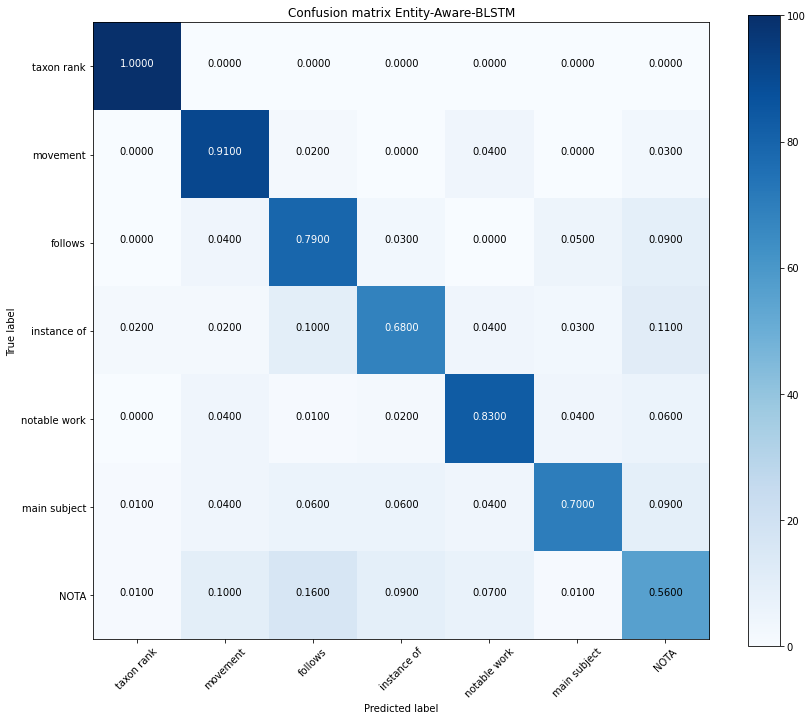

***** Eval results *****
   Accuracy: 0.781429
   Precision (macro-averaged): 0.781628
   Recall (macro-averaged): 0.781429
   F1-Score (macro-averaged): 0.778965

   Average time for inference of one sentence: 31.77 ms

***** Detailed classification report *****
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       0.79      0.91      0.85       100
           2       0.69      0.79      0.74       100
           3       0.77      0.68      0.72       100
           4       0.81      0.83      0.82       100
           5       0.84      0.70      0.77       100
           6       0.60      0.56      0.58       100

    accuracy                           0.78       700
   macro avg       0.78      0.78      0.78       700
weighted avg       0.78      0.78      0.78       700

time: 22.8 s


In [ ]:
if (use_fewrel_data):
    ######################## FewRel data files ########################
    # eval_data_file = 'fewrel-training-data/fewrel/dev_7_classes_disjoint.json'
    # eval_data_file = 'fewrel-training-data/fewrel/test_7_classes_disjoint.json'
    eval_data_file = 'fewrel-training-data/fewrel/train_7_classes_disjoint.json'
else:
    ################## Future-Engineering data files ##################
    eval_data_file = 'fe-training-data/val_examples_nota_manufact_operate_operatesth_order_uses_ordersth.json'
    # eval_data_file = 'fe-training-data/test_examples_nota_manufact_operate_operatesth_order_uses_ordersth.json'
    # eval_data_file = 'fe-training-data/train_examples_nota_manufact_operate_operatesth_order_uses_ordersth.json'

results = []
avg_infer_time = 0.0

with open(os.path.join(root, eval_data_file), 'r') as file:
    data = json.load(file)
    for sentence in data:
        ent1, ent2 = sentence['ents']

        before = time.time()
        pred_rel_label, logits = inferencer.infer_sentence(sentence['text'], ent1, ent2)
        after = time.time()

        if (logits is not None):
            logits = logits.detach().cpu().numpy()
            
        results.append((sentence['text'], ent1, ent2, sentence['label'], pred_rel_label, logits))
        avg_infer_time += (after - before) / len(data)

correct_labels = list(map(lambda x: rel2id_map[x], [i[3] for i in results]))
outputs = list(map(lambda x: rel2id_map[x], [i[4] for i in results]))

eval_accuracy, eval_precision, eval_recall, eval_f1, class_report = accuracy_precision_recall_f1(correct_labels, outputs)

class_labels = [id2rel_dict[x][0] for x in rel2id_map.keys()]
plot_confusion_matrix(confusion_matrix(correct_labels, outputs),class_labels, title=('Confusion matrix ' + inferencer.get_approach_name()))

print("***** Eval results *****")
print("   Accuracy: %f" % eval_accuracy)
print("   Precision (macro-averaged): %f" % eval_precision)
print("   Recall (macro-averaged): %f" % eval_recall)
print("   F1-Score (macro-averaged): %f" % eval_f1)
print("\n   Average time for inference of one sentence: %.2f ms" % (avg_infer_time*1000))

print("\n***** Detailed classification report *****")
print(class_report)

Write all incorrect classifications of the evaluation process to csv file.

In [ ]:
incorrect_predictions = [(result[0], result[1], result[2], result[3], result[4]) for result in results if result[3]!=result[4]]
os.makedirs(os.path.join(root, "incorrect_predictions/"), exist_ok=True)

if use_fewrel_data:
    data_type = "fewrel"
else:
    data_type = "fe"

with open(os.path.join(root, "incorrect_predictions/incorrect_predictions_" + data_type + "_" + inferencer.get_approach_name() + ".csv"),'w') as out_file:
    for prediction in incorrect_predictions:
        out_file.write('%s;%s;%s;%s;%s\n' % (prediction[0], prediction[1], prediction[2], prediction[3], prediction[4]))


### Evaluation of incorrect Predicitons

Reading all previously written csv files with the incorrect predictions

In [ ]:
import csv

if use_fewrel_data:
    incorrect_prediction_files = {'R-BERT':'incorrect_predictions_fewrel_R-BERT.csv', 
                              'BERT-Pair':'incorrect_predictions_fewrel_BERT-Pair.csv',
                              'MTB-BERT' : 'incorrect_predictions_fewrel_MTB-BERT.csv',
                              'BLSTM' : 'incorrect_predictions_fewrel_Entity-Aware-BLSTM.csv'}
else:
    incorrect_prediction_files = {'R-BERT':'incorrect_predictions_R-BERT.csv', 
                                  'BERT-Pair':'incorrect_predictions_BERT-Pair.csv',
                                  'MTB-BERT' : 'incorrect_predictions_MTB-BERT.csv',
                                  'BLSTM' : 'incorrect_predictions_Entity-Aware-BLSTM.csv'}

incorrect_predictions = dict()
sentences = dict()

for approach, incorrect_file in incorrect_prediction_files.items():
    incorrect_predictions[approach] = []
    sentences[approach] = set()
    with open(os.path.join(root, 'incorrect_predictions/' + incorrect_file)) as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=';')
        for prediction in csv_reader:
            incorrect_predictions[approach].append(prediction)
            sentences[approach].add(prediction[0])

Searching for sentences which were predicted wrong by all available approaches.

In [ ]:
all_equal_incorrect = [x for x in incorrect_predictions['R-BERT'] 
                        if x in incorrect_predictions['BERT-Pair'] and
                        x in incorrect_predictions['BLSTM'] and
                        x in incorrect_predictions['MTB-BERT']]

print('############ Equally incorrect predictions ############')
for incorrect in all_equal_incorrect:
    print(incorrect)

############ Equally incorrect predictions ############
["In July 2002 , Walker made his debut at the Commonwealth Games by competing in the men 's triathlon at the 2002 Manchester Games .", "['Q1116640', 107, 128, 0.5]", "['Q178340', 44, 62, 0.5]", 'P31', 'NOTA']
['When the Cretaceous – Paleogene extinction event occurred , ceratosaurians and two groups of orionideans within the clade Coelurosauria , the Tyrannosauroidea and Maniraptoriformes , were still extant .', "['Q134143', 163, 180, 0.5]", "['Q713623', 116, 121, 0.5]", 'P31', 'P105']
['Over the years , the club has hosted many Davis Cup ties of the Spanish team , including the Inter - Zonal final in 1965 .', "['Q2626593', 116, 120, 0.5]", "['Q132377', 42, 51, 0.5]", 'P31', 'NOTA']
['and Johnston formed a joint venture with Sir William Arrol , an engineer of the Forth Bridge to form the Mo - Car Syndicate Limited , which was to produce his car .', "['Q337783', 41, 58, 0.5]", "['Q275', 80, 92, 0.5]", 'P800', 'NOTA']
['Procaccini i

Counting number of incorrect predictions and the number of unique sentence sequences for all approaches.

In [ ]:
for approach in incorrect_predictions.keys():
    print('############ %s ############' % approach)
    print('Number of incorrect predictions: %d' % len(incorrect_predictions[approach]))
    print('Number of unique sentences in incorrect predictions: %d' % len(sentences[approach]))

############ R-BERT ############
Number of incorrect predictions: 75
Number of unique sentences in incorrect predictions: 75
############ BERT-Pair ############
Number of incorrect predictions: 159
Number of unique sentences in incorrect predictions: 159
############ MTB-BERT ############
Number of incorrect predictions: 109
Number of unique sentences in incorrect predictions: 109
############ BLSTM ############
Number of incorrect predictions: 153
Number of unique sentences in incorrect predictions: 153
time: 2.59 ms


## Evaluation of R-BERT inferencer with Lime framework

The evaluation with LIME is only implemented for R-BERT inferencer.

Please also note that the evaluation with the Lime Framework without GPU support takes a very long time and is therefore not recommended.

In [ ]:
inferencer = RBertInferencer(rbert_num_labels, rbert_max_seq_length, rbert_finetuning_checkpoint, rbert_label_map)

Definition of multiple sentences for LIME evaluation. 

In [ ]:
class LimeExample():
    def __init__(self, sentence, ent1, ent2, ent1_string, ent2_string, relation):
        self.sentence = sentence
        self.ent1 = ent1
        self.ent2 = ent2
        self.ent1_string = ent1_string
        self.ent2_string = ent2_string
        self.relation = relation

lime_examples = []

lime_examples.append(LimeExample('VAG is also testing the operation of Hybrid models on some of their lines in Nuremberg.', 
                                 ['Hybrid', 37, 43, 1.0], 
                                 ['Nuremberg', 77, 86, 1.0], 
                                 'Hybrid', 
                                 'Nuremberg', 
                                 'NOTA'))

# lime_examples.append(LimeExample('VAG utilizes electric Citaro buses since 2018.', 
#                                  ['VAG', 0, 3, 1.0], 
#                                  ['Citaro', 22, 28, 1.0], 
#                                  'VAG', 
#                                  'Citaro', 
#                                  'A operates B'))

# lime_examples.append(LimeExample('Mercedes Benz is the producer of the popular Citaro electric bus model.', 
#                                  ['Mercedes Benz', 0, 13, 1.0], 
#                                  ['Citaro', 45, 51, 1.0], 
#                                  'Mercedes Benz', 
#                                  'Citaro', 
#                                  'A manufactures product B'))

# lime_examples.append(LimeExample('VAG is also testing the operation of Hybrid models on some of their lines in Nuremberg.', 
#                                  ['VAG', 0, 3, 1.0], 
#                                  ['Nuremberg', 77, 86, 1.0], 
#                                  'VAG', 
#                                  'Nuremberg', 
#                                  'A operates \[something\] in location B'))

# lime_examples.append(LimeExample('VAG is also testing the operation of Hybrid models on some of their lines in Nuremberg.', 
#                                  ['VAG', 0, 3, 1.0], 
#                                  ['Hybrid', 37, 43, 1.0], 
#                                  'VAG', 
#                                  'Hybrid', 
#                                  'A operates B'))

# lime_examples.append(LimeExample('Therefore, VAG placed an order for five more buses from Volvo.', 
#                                  ['VAG', 11, 14, 1.0], 
#                                  ['Volvo', 56, 61, 1.0], 
#                                  'VAG', 
#                                  'Volvo', 
#                                  'A orders something from B'))

# lime_examples.append(LimeExample("The ordered buses are Volvo's popular Volvo 7900 model, which uses the Pantograph technology to charge at selected bus stops.", 
#                                  ['Volvo', 22, 27, 1.0], 
#                                  ['Volvo 7900', 38, 48, 1.0], 
#                                  'Volvo', 
#                                  'Volvo 7900', 
#                                  'A manufactures product B'))

# lime_examples.append(LimeExample("The ordered buses are Volvo's popular Volvo 7900 model, which uses the Pantograph technology to charge at selected bus stops.", 
#                                  ['Volvo', 22, 27, 1.0],
#                                  ['Pantograph', 71, 81, 1.0],
#                                  'Volvo', 
#                                  'Pantograph', 
#                                  'A uses/employs charging technology B'))

# lime_examples.append(LimeExample("The ordered buses are Volvo's popular Volvo 7900 model, which uses the Pantograph technology to charge at selected bus stops.", 
#                                  ['Volvo 7900', 38, 48, 1.0],
#                                  ['Pantograph', 71, 81, 1.0],
#                                  'Volvo 7900', 
#                                  'Pantograph', 
#                                  'A uses/employs charging technology B'))

Explanation of the previously defined sentences with LIME framework printing the resulting graphics for each sentence.

In [ ]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=[id2rel_dict[x][0] for x in rel2id_map])
label_list = rel2id_map.values()


for lime_example in lime_examples:
    print('Sentence: %s' % lime_example.sentence)
    print('Entity 1: %s - %s' % (lime_example.ent1_string, lime_example.ent1))
    print('Entity 2: %s - %s' % (lime_example.ent2_string, lime_example.ent2))
    print('Correct label: %s' % id2rel_dict[lime_example.relation][0])
    print('Predicted label: %s' % id2rel_dict[inferencer.infer_sentence(lime_example.sentence, lime_example.ent1, lime_example.ent2)[0]][0])
    print('\n')

    inferencer.set_entity_strings_for_lime_prediction(lime_example.ent1_string, lime_example.ent2_string)
    exp = explainer.explain_instance(lime_example.sentence, inferencer.infer_sentence_lime, num_features=8, labels=label_list)

    exp.show_in_notebook(text=False)
    exp.show_in_notebook(text=lime_example.sentence, labels=(rel2id_map[lime_example.relation],))

Output hidden; open in https://colab.research.google.com to view.